In [22]:
import copy
import re
import numpy as np
import pandas as pd
import fsspec
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from fuzzywuzzy import fuzz
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

### Data preprocessing

- Load data

In [23]:
# Load data
df_ba =  pd.read_csv('./emotion_scores_ba.csv')

# Load user data
file_path = '.\\matched_beer_data\\users.csv' 
user = pd.read_csv(file_path)
new_columns = user.iloc[0]
user = user[1:]

seen_names = {}
new_column_names = []
for name in new_columns:
    if name in seen_names:
        seen_names[name] += 1
        new_column_names.append(f'{name}_{seen_names[name]}')
    else:
        seen_names[name] = 0
        new_column_names.append(name)

user.columns = new_column_names

In [24]:
# Mapping country
url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/" \
      "download/110m/cultural/ne_110m_admin_0_countries.zip"
    
with fsspec.open(f"simplecache::{url}") as file:
    world = gpd.read_file(file)
    
# Mapping user location names to gpd location names
location = []
for item1 in user['location'].values:
    closest_match = None
    highest_similarity = 0
    for item2 in world['SOVEREIGNT'].values:
        similarity = fuzz.ratio(item1, item2)
        if similarity > highest_similarity:
            closest_match = item2
            highest_similarity = similarity
    location.append(closest_match)
    
user['country'] = location

- Data processing

In [25]:
# Merge data
ba_user = pd.merge(df_ba, user[['user_id', 'country', 'location']], on='user_id', how='left')

# Drop duplicate text
df_ba_filtered = df_ba.drop_duplicates(subset = ['text'])
ba_user_filtered = ba_user.drop_duplicates(subset=['text']).copy()
ba_user_filtered.dropna(inplace=True)

# 4.1.1 Regional distribution of reviews’ emotion

In [26]:
# Process regional data
ba_country = ba_user_filtered[pd.notna(ba_user_filtered['country'])]

## 1) Distribution of emotional score in different countries

- boxplot

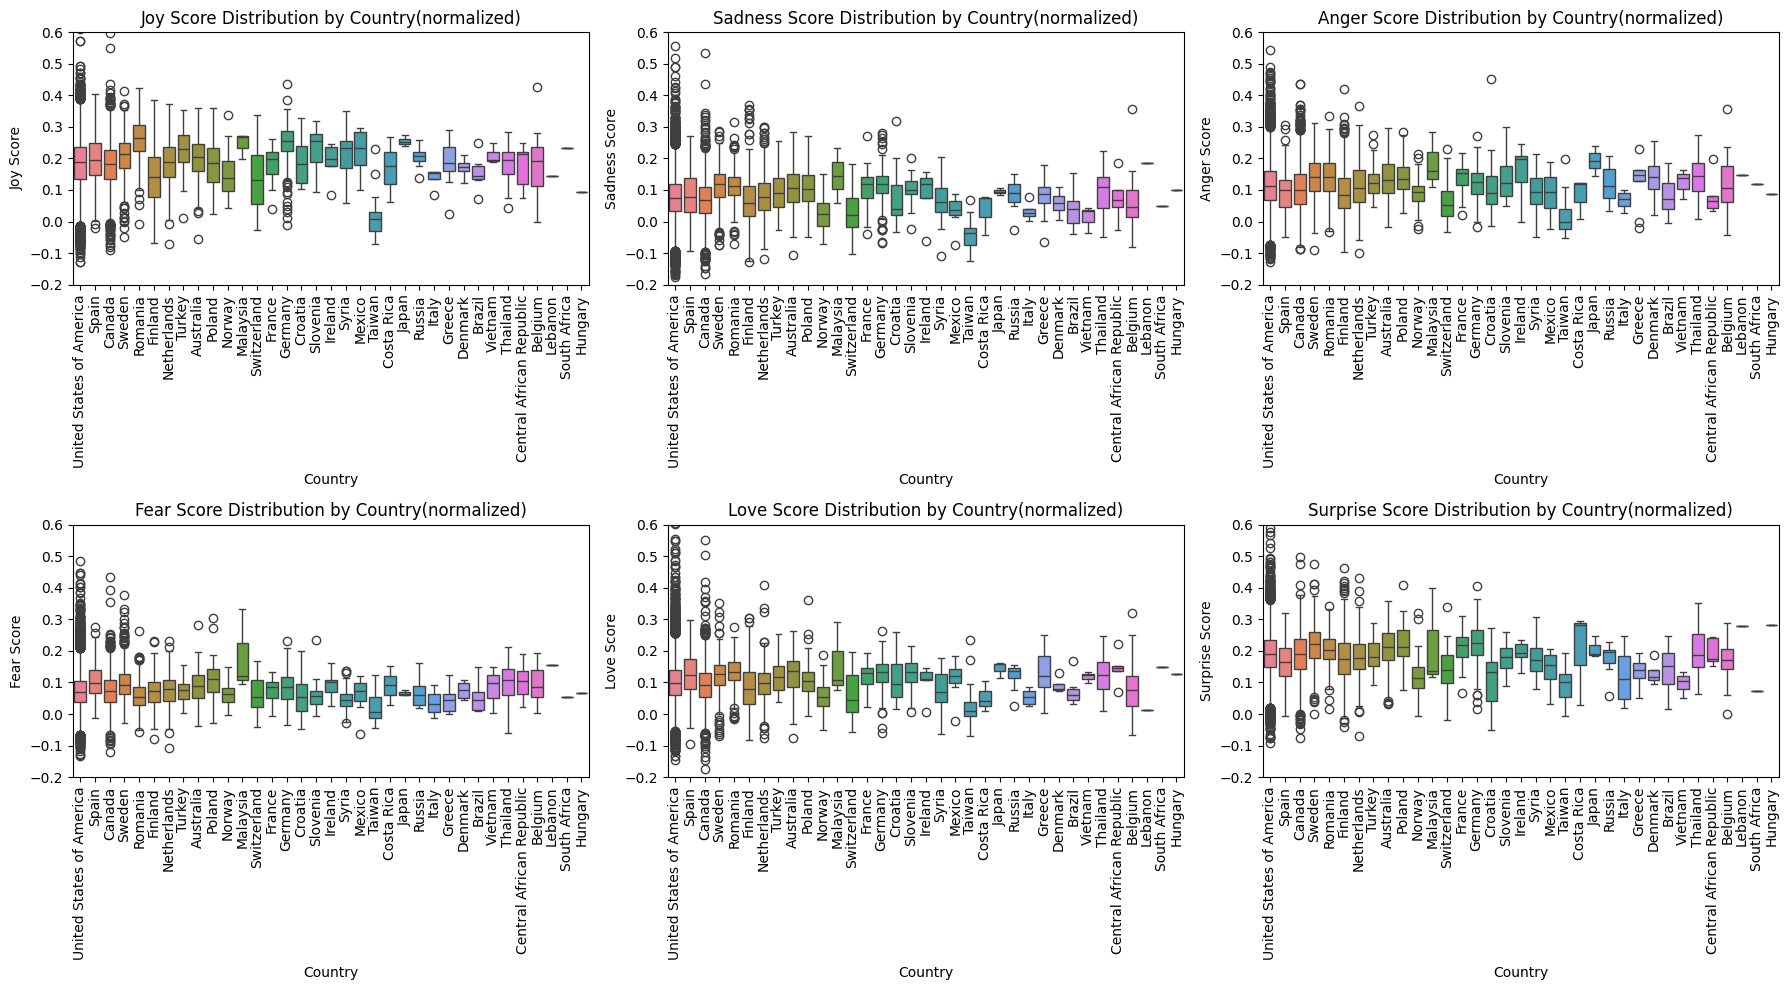

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

emotions = ['joy_score', 'sadness_score', 'anger_score', 'fear_score', 'love_score', 'surprise_score']

# Boxplot
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='country', y=emotions[i], data=ba_country, ax=ax, hue = 'country')
    ax.set_ylim(-0.2, 0.6)
    ax.set_title(f'{emotions[i].replace("_", " ").title()} Distribution by Country(normalized)')
    ax.set_xlabel('Country')
    ax.set_ylabel(emotions[i].replace("_", " ").title())
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### USA distribution(Delete it if useless)

In [28]:
USA = ba_country[ba_country['location'].str.startswith('United States')]

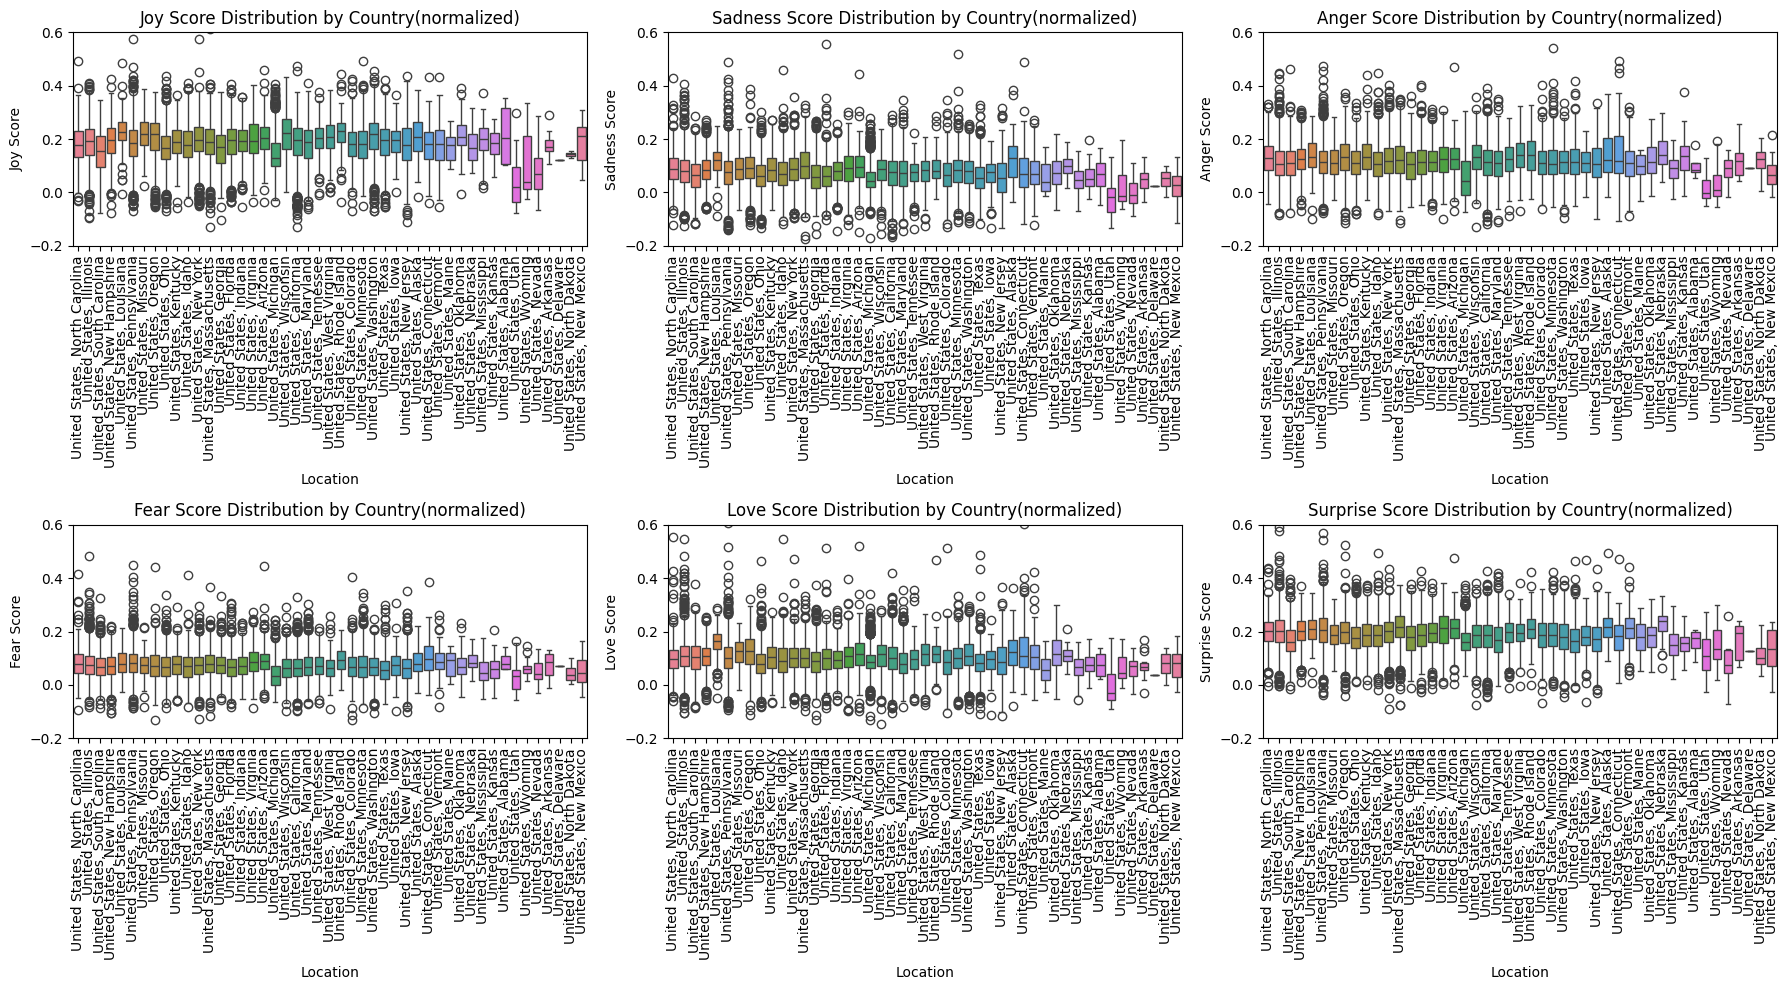

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

emotions = ['joy_score', 'sadness_score', 'anger_score', 'fear_score', 'love_score', 'surprise_score']

# Boxplot
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='location', y=emotions[i], data=USA, ax=ax, hue = 'location')
    ax.set_ylim(-0.2, 0.6)
    ax.set_title(f'{emotions[i].replace("_", " ").title()} Distribution by Country(normalized)')
    ax.set_xlabel('Location')
    ax.set_ylabel(emotions[i].replace("_", " ").title())
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# 4.1.2 Correlation between emotion and beer’s characteristics (appearance, aroma, taste)

In [30]:
beer_characteristics = ['appearance', 'aroma', 'taste']
emotions = ['joy_score', 'sadness_score', 'anger_score', 'fear_score', 'love_score', 'surprise_score']

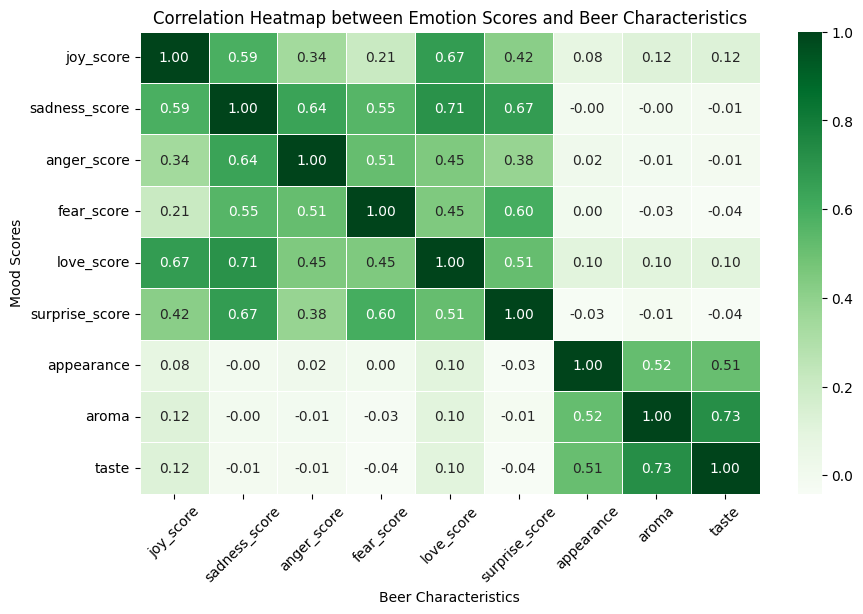

In [31]:
data = pd.DataFrame(np.random.rand(100, 9), columns=['joy_score', 'sadness_score', 'anger_score', 'fear_score', 'love_score', 'surprise_score', 'appearance', 'aroma', 'taste'])

correlation_matrix = ba_user_filtered[['joy_score', 'sadness_score', 'anger_score', 'fear_score', 'love_score', 'surprise_score', 'appearance', 'aroma', 'taste']].corr()

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=.5)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Correlation Heatmap between Emotion Scores and Beer Characteristics')
plt.xlabel('Beer Characteristics')
plt.ylabel('Mood Scores')
plt.show()

Create scatter plots of each characteristics and mood score to observe if there is an intuitive correlation.

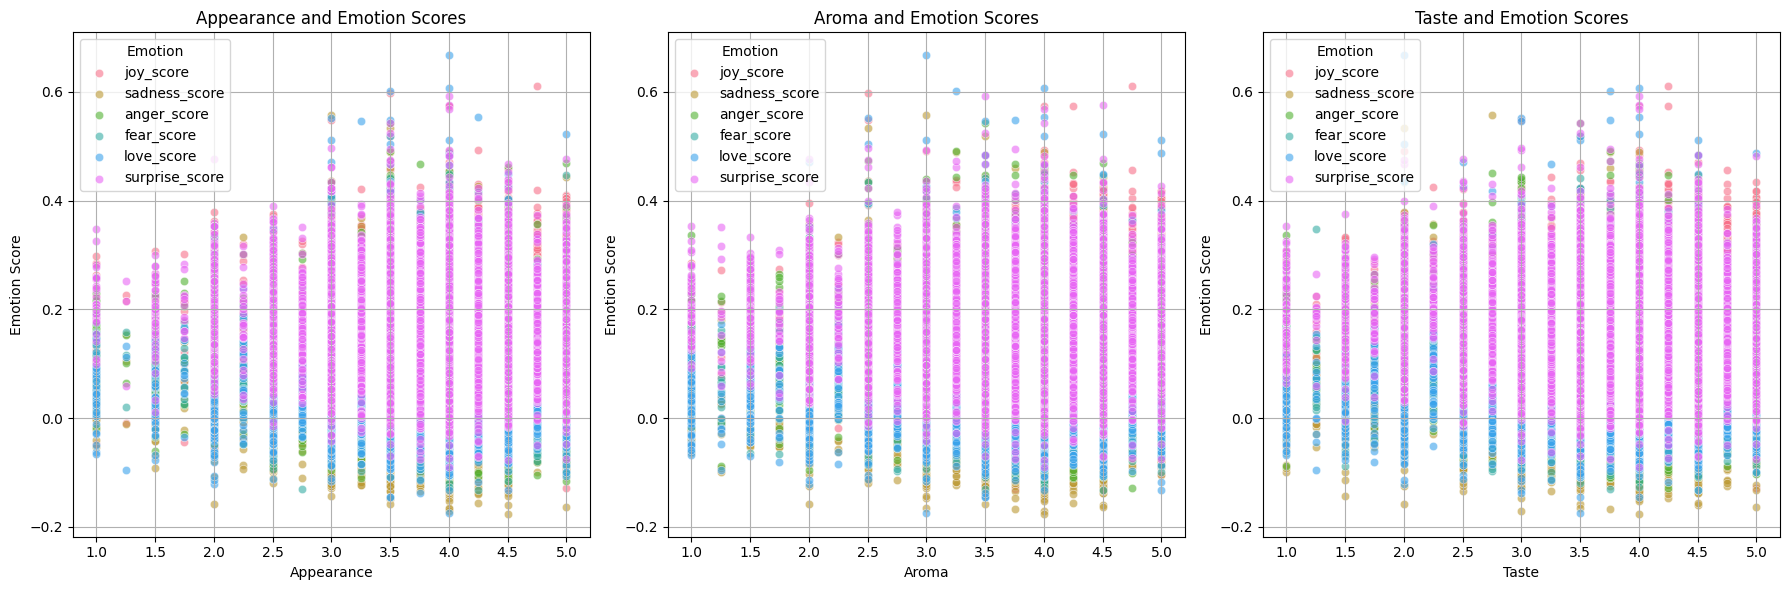

In [32]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.set_palette("husl")

# Iterate through beer_characteristics to create scatter plots in each subplot
for i, characteristic in enumerate(beer_characteristics):
    ax = axes[i]  # Select the current subplot
    for emotion in emotions:
        sns.scatterplot(data=ba_user_filtered, x=characteristic, y=emotion, label=emotion, alpha=0.6,ax=ax)
    
    ax.set_title(f'{characteristic.capitalize()} and Emotion Scores')
    ax.set_xlabel(characteristic.capitalize())
    ax.set_ylabel('Emotion Score')
    ax.legend(title='Emotion')
    ax.grid(True)

plt.tight_layout()
plt.show()

Calculate the correlation coefficient and perform t-test to test the significance of correlation (p-value).

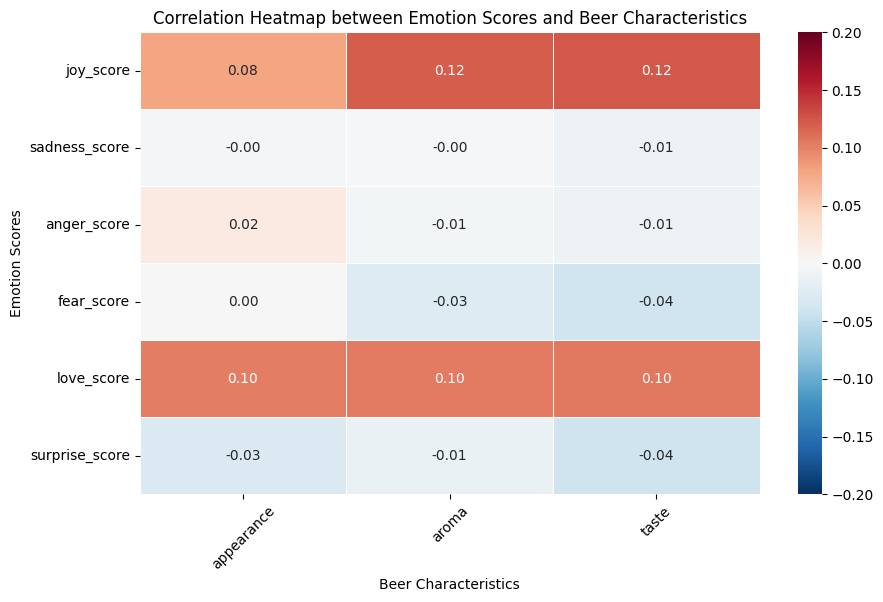

In [33]:
# Calculate the correlation coefficient
correlation_matrix = np.empty((len(emotions), len(beer_characteristics)))

for i, emotion in enumerate(emotions):
    for j, characteristic in enumerate(beer_characteristics):
        correlation_matrix[i, j] = ba_user_filtered[emotion].corr(ba_user_filtered[characteristic])

# Create heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt=".2f",linewidths=.5, center=0, vmin=-0.2, vmax=0.2)


heatmap.set_xticklabels(beer_characteristics, rotation=45)
heatmap.set_yticklabels(emotions, rotation=0)

plt.title('Correlation Heatmap between Emotion Scores and Beer Characteristics')
plt.xlabel('Beer Characteristics')
plt.ylabel('Emotion Scores')
plt.show()

In [34]:
# Assuming ba_user_filtered contains the relevant data
results = []

alpha = 0.05  # Significance level

for emotion in emotions:
    for characteristic in beer_characteristics:
        correlation_coefficient, p_value = stats.pearsonr(ba_user_filtered[emotion], ba_user_filtered[characteristic])
        
        correlation_result = 'Significant' if p_value < alpha else 'Not significant'
        
        result = {
            'Emotion': emotion,
            'Characteristic': characteristic,
            'Correlation Coefficient': correlation_coefficient,
            'P-value': p_value,
            'Result': correlation_result
        }
        results.append(result)

# Create a DataFrame and display the results
results_df = pd.DataFrame(results)
display(results_df)

,Emotion,Characteristic,Correlation Coefficient,P-value,Result
0,joy_score,appearance,0.079163,4.467907e-51,Significant
1,joy_score,aroma,0.120617,1.375344e-116,Significant
2,joy_score,taste,0.123997,3.759321e-123,Significant
3,sadness_score,appearance,-0.003979,4.505793e-01,Not significant
4,sadness_score,aroma,-0.002067,6.951798e-01,Not significant
5,sadness_score,taste,-0.011174,3.412383e-02,Significant
6,anger_score,appearance,0.018368,4.960425e-04,Significant
7,anger_score,aroma,-0.006095,2.478380e-01,Not significant
8,anger_score,taste,-0.010349,4.972626e-02,Significant
9,fear_score,appearance,0.000043,9.934969e-01,Not significant


# 4.2.1 Correlation between emotion and beer ratings

- For each beer, calculate its average rating as the rating of a certain beer.

In [35]:
# Calculate the average rating of each beer
beer_rating = df_ba.groupby('beer_id')['rating'].mean()

# Calculate the average mood score of each beer
beer_emotion_score = df_ba.groupby('beer_id')[emotions].mean()

- Create the scatter plot to roughly observe the correlation between beer rating and emotion score

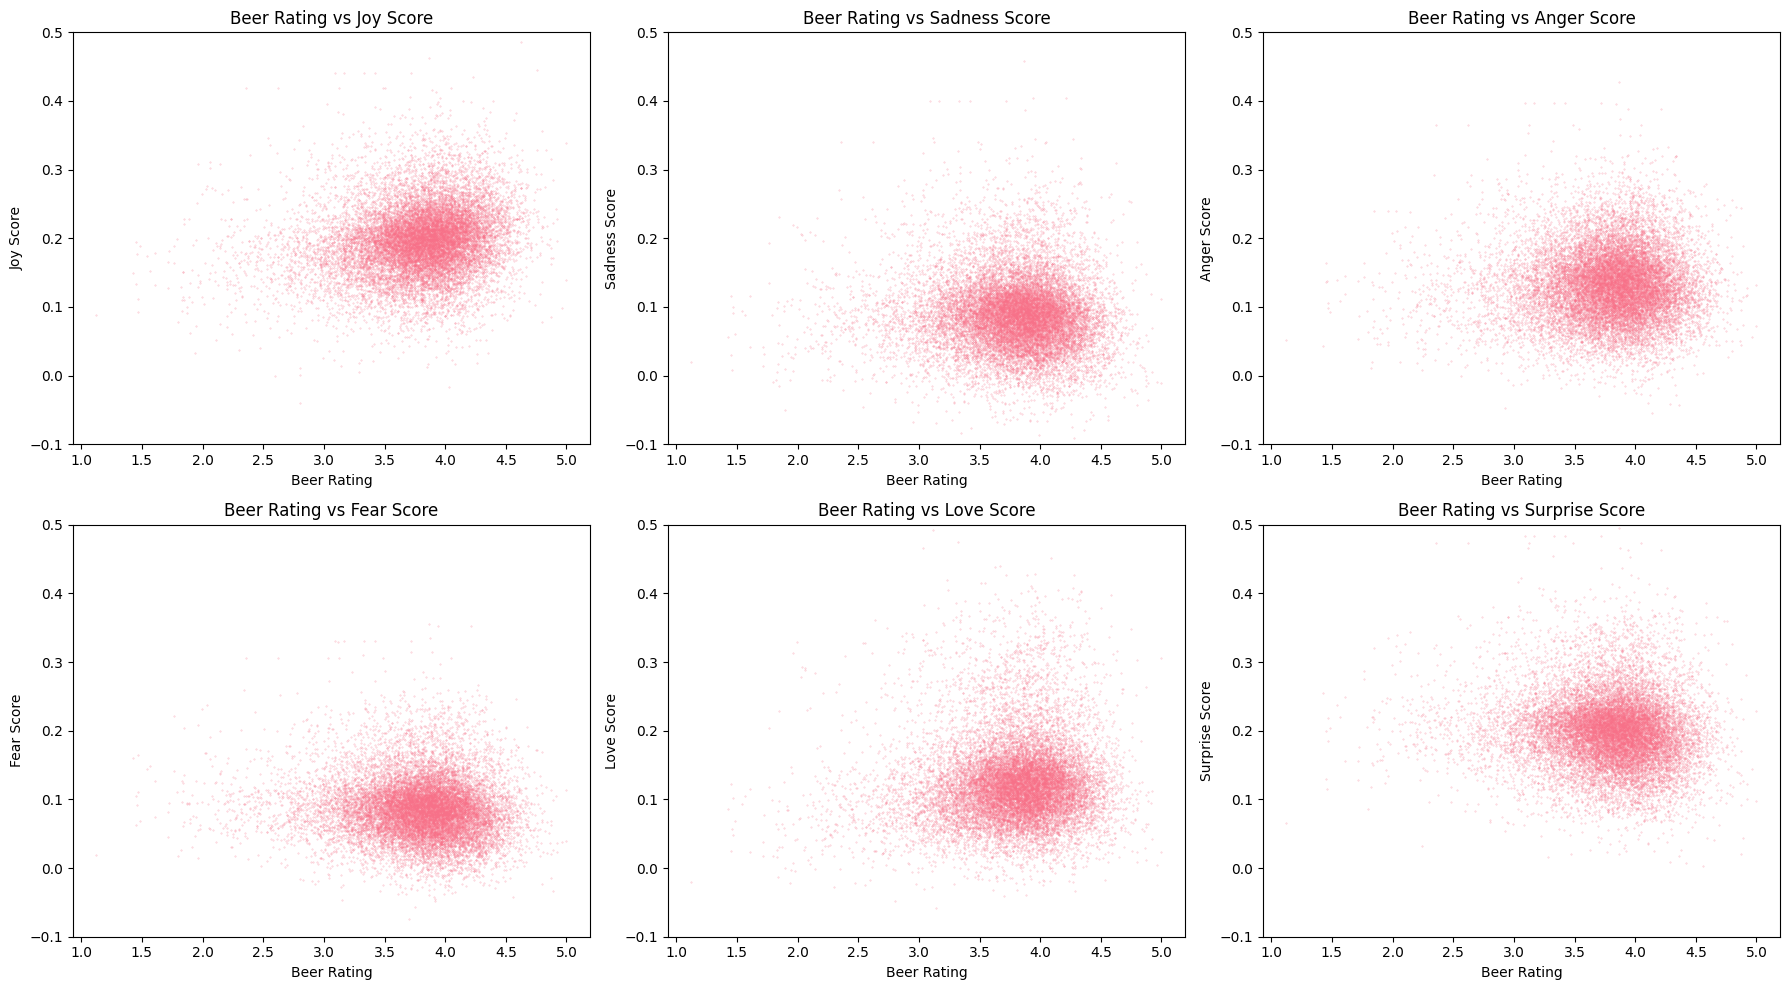

In [36]:
# Create the scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Joy score vs Beer rating
axes[0, 0].scatter(beer_rating, beer_emotion_score['joy_score'], alpha=0.5, s=0.1)
axes[0, 0].set_title('Beer Rating vs Joy Score')
axes[0, 0].set_ylim(-0.1, 0.5)
axes[0, 0].set_xlabel('Beer Rating')
axes[0, 0].set_ylabel('Joy Score')

# Sadness score vs Beer rating
axes[0, 1].scatter(beer_rating, beer_emotion_score['sadness_score'], alpha=0.5, s=0.1)
axes[0, 1].set_title('Beer Rating vs Sadness Score')
axes[0, 1].set_ylim(-0.1, 0.5)
axes[0, 1].set_xlabel('Beer Rating')
axes[0, 1].set_ylabel('Sadness Score')

# Anger score vs Beer rating
axes[0, 2].scatter(beer_rating, beer_emotion_score['anger_score'], alpha=0.5, s=0.1)
axes[0, 2].set_title('Beer Rating vs Anger Score')
axes[0, 2].set_ylim(-0.1, 0.5)
axes[0, 2].set_xlabel('Beer Rating')
axes[0, 2].set_ylabel('Anger Score')

# Fear score vs Beer rating
axes[1, 0].scatter(beer_rating, beer_emotion_score['fear_score'], alpha=0.5, s=0.1)
axes[1, 0].set_title('Beer Rating vs Fear Score')
axes[1, 0].set_ylim(-0.1, 0.5)
axes[1, 0].set_xlabel('Beer Rating')
axes[1, 0].set_ylabel('Fear Score')

# Love score vs Beer rating
axes[1, 1].scatter(beer_rating, beer_emotion_score['love_score'], alpha=0.5, s=0.1)
axes[1, 1].set_title('Beer Rating vs Love Score')
axes[1, 1].set_ylim(-0.1, 0.5)
axes[1, 1].set_xlabel('Beer Rating')
axes[1, 1].set_ylabel('Love Score')

# Surprise score vs Beer rating
axes[1, 2].scatter(beer_rating, beer_emotion_score['surprise_score'], alpha=0.5, s=0.1)
axes[1, 2].set_title('Beer Rating vs Surprise Score')
axes[1, 2].set_ylim(-0.1, 0.5)
axes[1, 2].set_xlabel('Beer Rating')
axes[1, 2].set_ylabel('Surprise Score')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

According to the scatter plot of beer ratings and different mood scores, all plots show a dense clustering of points around the middle range of beer ratings (around 2.5 to 4.0). It seems there is no immediately obvious strong linear relationship in the plots, but it can be observed that beer ratings has a slight positive correlation with joy score and love score and a slight negative correlation with fear score and surprise score.

- Calculate the correlation coefficient and perform t-test to test the significance of correlation (p-value).

In [37]:
# Results list
correlation_results = []

# Calculate Pearson correlation coefficient and p-value for each emotion score
for emotion in emotions:
    corr_coeff, p_value = pearsonr(beer_rating, beer_emotion_score[emotion])
    correlation_results.append({'emotion': emotion, 'correlation_coefficient': corr_coeff, 'p_value': p_value})

# Display the ruselts
correlation_results_df = pd.DataFrame(correlation_results)
correlation_results_df.set_index('emotion', inplace=True)
display(correlation_results_df)

,correlation_coefficient,p_value
emotion,,
joy_score,0.174194,2.989209e-110
sadness_score,-0.057861,1.841816e-13
anger_score,0.019445,1.345439e-02
fear_score,-0.085930,7.315182e-28
love_score,0.060130,2.025115e-14
surprise_score,-0.085671,1.052748e-27


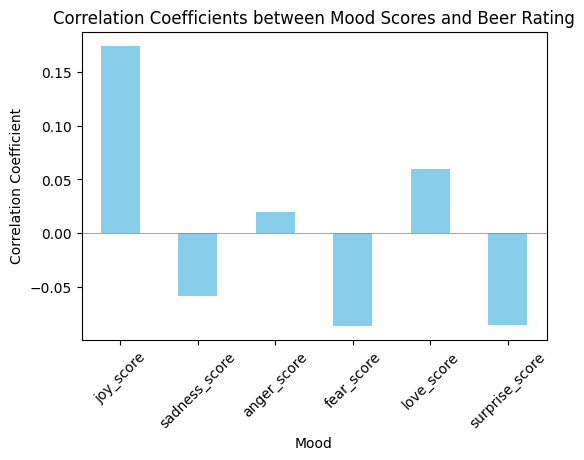

In [38]:
plt.figure(figsize=(6,4))
correlation_results_df['correlation_coefficient'].plot(kind='bar', color='skyblue')
plt.title('Correlation Coefficients between Mood Scores and Beer Rating')
plt.xlabel('Mood')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

# 4.2.2 Correlation between mood and ABV

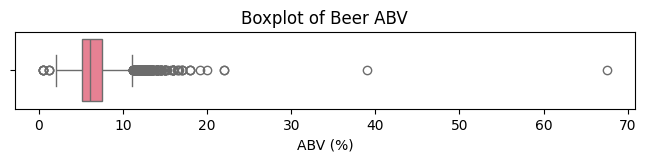

In [39]:
# ABV for each beer
beer_abv = df_ba.groupby('beer_id')['abv'].mean()

# Create a boxplot to show the distribution of beer_abv
plt.figure(figsize=(8, 1))
sns.boxplot(x=beer_abv)
plt.title('Boxplot of Beer ABV')
plt.xlabel('ABV (%)')
plt.show()

- Create the scatter plot to roughly observe the correlation between ABV and emotion score.

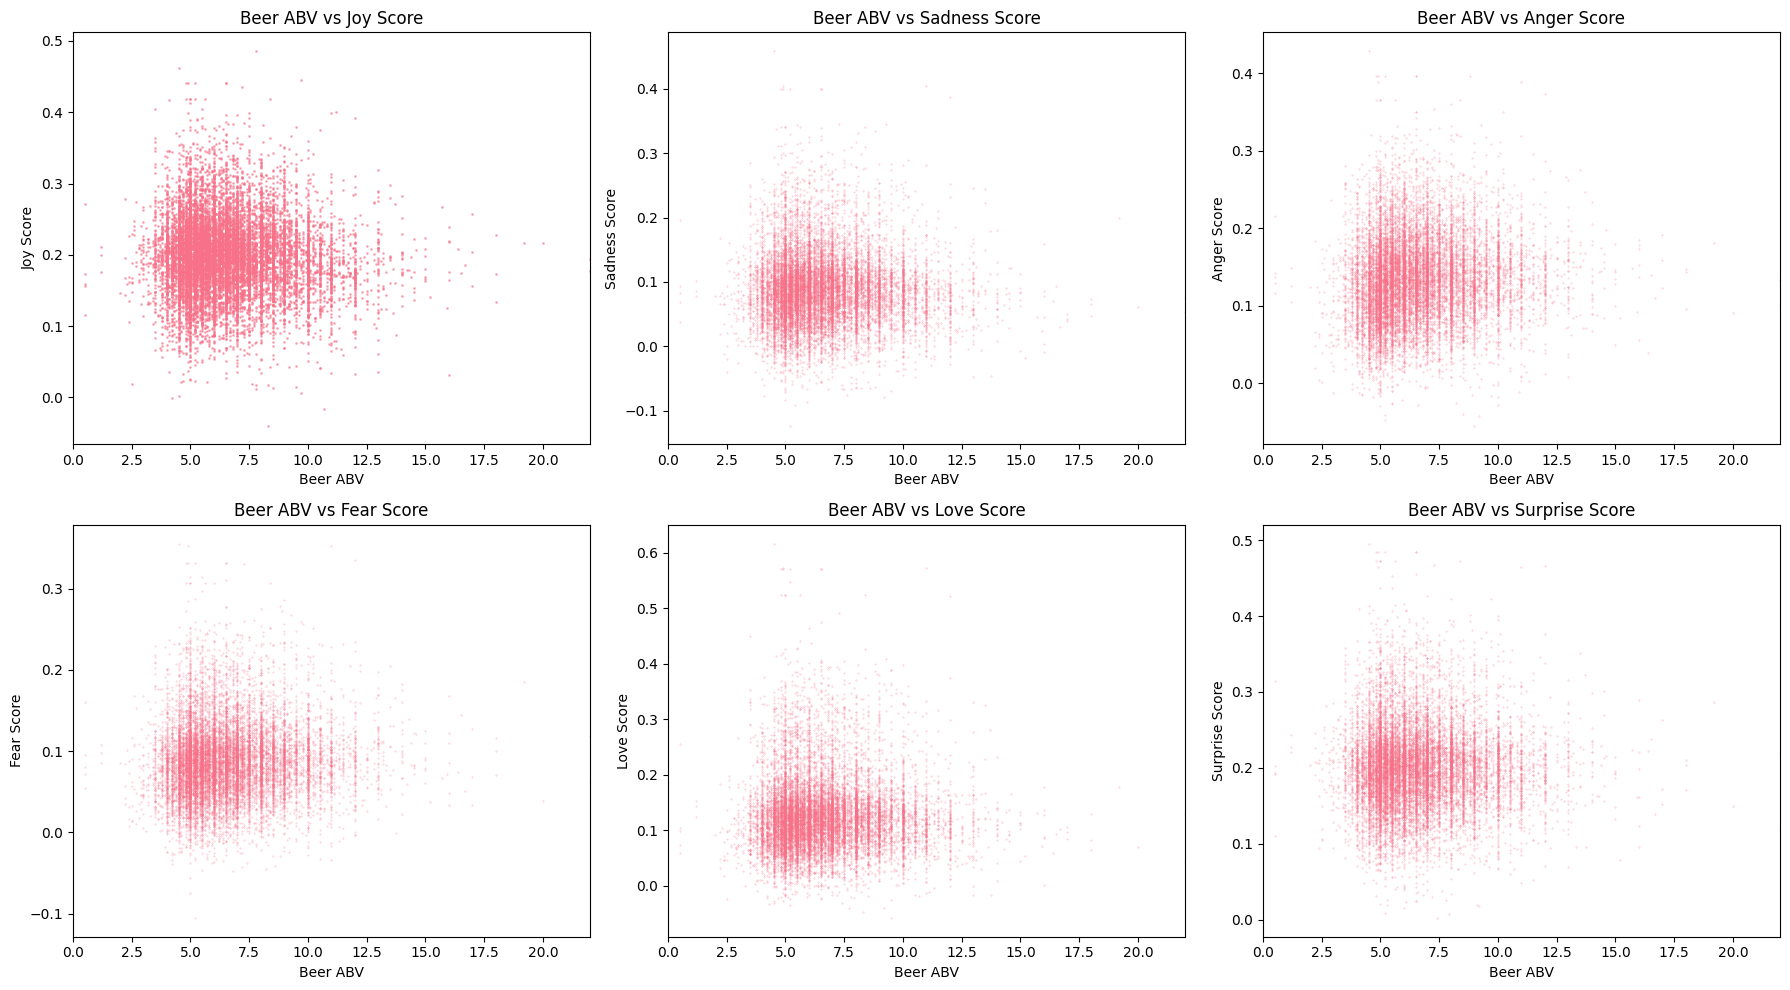

In [40]:
# Create the scatter plot
# Set up the matplotlib figure and axes, one for each scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Joy score vs Beer abv
axes[0, 0].scatter(beer_abv, beer_emotion_score['joy_score'], alpha=0.5, s=1)
axes[0, 0].set_title('Beer ABV vs Joy Score')
axes[0, 0].set_xlim(0, 22)
axes[0, 0].set_xlabel('Beer ABV')
axes[0, 0].set_ylabel('Joy Score')

# Sadness score vs Beer abv
axes[0, 1].scatter(beer_abv, beer_emotion_score['sadness_score'], alpha=0.5, s=0.1)
axes[0, 1].set_title('Beer ABV vs Sadness Score')
axes[0, 1].set_xlim(0, 22)
axes[0, 1].set_xlabel('Beer ABV')
axes[0, 1].set_ylabel('Sadness Score')

# Anger score vs Beer abv
axes[0, 2].scatter(beer_abv, beer_emotion_score['anger_score'], alpha=0.5, s=0.1)
axes[0, 2].set_title('Beer ABV vs Anger Score')
axes[0, 2].set_xlim(0, 22)
axes[0, 2].set_xlabel('Beer ABV')
axes[0, 2].set_ylabel('Anger Score')

# Fear score vs Beer abv
axes[1, 0].scatter(beer_abv, beer_emotion_score['fear_score'], alpha=0.5, s=0.1)
axes[1, 0].set_title('Beer ABV vs Fear Score')
axes[1, 0].set_xlim(0, 22)
axes[1, 0].set_xlabel('Beer ABV')
axes[1, 0].set_ylabel('Fear Score')

# Love score vs Beer abv
axes[1, 1].scatter(beer_abv, beer_emotion_score['love_score'], alpha=0.5, s=0.1)
axes[1, 1].set_title('Beer ABV vs Love Score')
axes[1, 1].set_xlim(0, 22)
axes[1, 1].set_xlabel('Beer ABV')
axes[1, 1].set_ylabel('Love Score')

# Surprise score vs Beer abv
axes[1, 2].scatter(beer_abv, beer_emotion_score['surprise_score'], alpha=0.5, s=0.1)
axes[1, 2].set_title('Beer ABV vs Surprise Score')
axes[1, 2].set_xlim(0, 22)
axes[1, 2].set_xlabel('Beer ABV')
axes[1, 2].set_ylabel('Surprise Score')

plt.tight_layout()
plt.show()

Calculate the correlation coefficient and perform t-test to test the significance of correlation (p-value).

In [41]:
# Results list
correlation_results = []

# Calculate Pearson correlation coefficient and p-value for each emotion score
for emotion in emotions:
    corr_coeff, p_value = pearsonr(beer_abv, beer_emotion_score[emotion])
    correlation_results.append({'emotion': emotion, 'correlation_coefficient': corr_coeff, 'p_value': p_value})

# Display the ruselts
correlation_results_df = pd.DataFrame(correlation_results)
correlation_results_df.set_index('emotion', inplace=True)
display(correlation_results_df)

,correlation_coefficient,p_value
emotion,,
joy_score,-0.051530,5.621114e-11
sadness_score,-0.022016,5.134545e-03
anger_score,0.085528,1.286875e-27
fear_score,0.058821,7.306230e-14
love_score,-0.001589,8.400013e-01
surprise_score,-0.005491,4.852440e-01


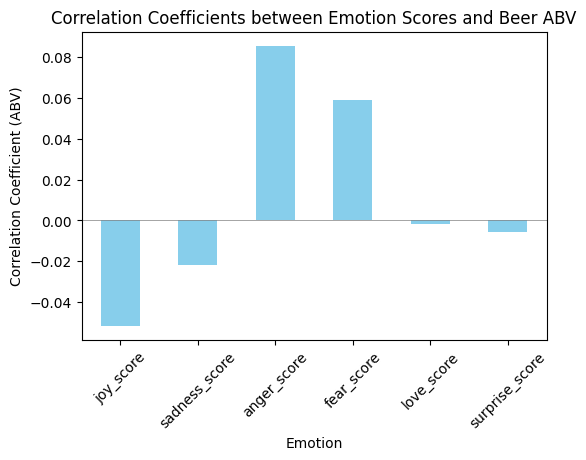

In [42]:
plt.figure(figsize=(6,4))
correlation_results_df['correlation_coefficient'].plot(kind='bar', color='skyblue')
plt.title('Correlation Coefficients between Emotion Scores and Beer ABV')
plt.xlabel('Emotion')
plt.ylabel('Correlation Coefficient (ABV)')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

The correlation between abv and mood is very small. Among them, there is a relatively significant positive correlation between `anger_score` and `abv` with a correlation coefficient of about 0.0855, a weak positive correlation between `fear_score` and `abv`, and a weak negative correlation between `joy_score` and `abv`, and all of them correspond to extremely small p-values, so we can consider the correlation significant.

The correlation between `love_score` and `surprise_score` and `abv` is very low and has a relatively large p-value, so it is considered that these two kinds of mood are not correlated with abv.